In [1]:
import sys
import os
from pathlib import Path

current_dir = os.getcwd()

file = Path(current_dir).resolve()
sys.path.append(str(file.parents[0]))

In [2]:
from argparse import Namespace
from data.bids_dataset import BidsDataset
from utils.brats_tools import temperature_scaled_softmax
import torch
from utils.brats_tools import plot_slices, get_central_slice
relu = torch.nn.ReLU()
softmax = torch.nn.Softmax(dim=0)

In [ ]:
data_dir = '/home/student/farid_ma/dev/multiclass_softseg/MulticlassSoftSeg/data/external/ASNR-MICCAI-BraTS2023-GLI-Challenge'

In [4]:
def round_probs(probs,tolerance = 1000):
    return torch.round(probs*tolerance)/tolerance

In [5]:
def print_unique_etc(tensor):
    print(f"unique values in soft gt: {torch.unique(tensor)}")
    print(f"unique sums across all channels {torch.unique(tensor.sum(dim=0), return_counts=True)}") 

In [6]:
def norm_relu(probs):
    if bool(relu(probs).max()):
        normalized_probs = relu(probs)/relu(probs).max() 
    else:
        normalized_probs  = relu(probs)  # applying ReLU to the logits to get probabilites
    return normalized_probs

In [7]:
def prob_normalization(probs, temperature):
    print(f"Soft Probs:")
    print_unique_etc(probs)
    print(f"---------------")
    print(f"Softmaxed Probs:")
    print_unique_etc(softmax(probs))
    print(f"---------------")
    print(f"Normalized Relu Probs:")
    print_unique_etc(norm_relu(probs))
    print(f"---------------")
    print(f"Temperature Softmaxed Probs")
    print_unique_etc(temperature_scaled_softmax(probs, temperature=temperature))

In [8]:
def test_temp_softmax(probs):
    values = (0.1, 0.15, 0.2, 0.25, 0.3)
    print(f"normal vals:")
    print_unique_etc(probs)
    print(f"------------------------------------")
    for temp in values:
        print(f"Temperature: {temp}")
        print_unique_etc(temperature_scaled_softmax(probs, temperature=temp))
        print(f"------------------------------------")

# Experiment 1

In [24]:
dilate = 0
conf = Namespace(resize = (152, 192, 144), contrast = 'multimodal', one_hot = False, sigma = 0.25, do2D = False, soft=False, dilate=dilate, binary=False, ds_factor=None, experiment = 1)
bids_ds = BidsDataset(conf, data_dir+'/train')

In [25]:
idx = 0
sample = bids_ds[idx]
sample_img = sample['img']
sample_gt = sample['seg']
sample_soft_gt = sample['soft_seg']

 soft gt tensor shape before one_hot encoding torch.Size([240, 240, 155])
 soft gt tensor shape after one_hot encoding torch.Size([4, 240, 240, 155])
 soft gt tensor shape after softening torch.Size([4, 240, 240, 155])


## Looking at unique values etc.

In [27]:
test_temp_softmax(round_probs(sample_soft_gt, 1000))

normal vals:
unique values in soft gt: tensor([0.0000, 0.0010, 0.0020, 0.9980, 0.9990, 1.0000])
unique sums across all channels (metatensor([0.9990, 1.0000, 1.0010]), metatensor([   2172, 4200034,     290]))
------------------------------------
Temperature: 0.1
unique values in soft gt: tensor([4.5394e-05, 4.5850e-05, 4.5850e-05, 4.5850e-05, 4.5850e-05, 4.5850e-05,
        4.5850e-05, 4.6311e-05, 4.6311e-05, 4.6311e-05, 4.6311e-05, 4.6311e-05,
        4.6311e-05, 4.6311e-05, 4.6311e-05, 4.6776e-05, 4.6776e-05, 4.6776e-05,
        4.7246e-05, 4.7246e-05, 9.9986e-01, 9.9986e-01, 9.9986e-01, 9.9986e-01,
        9.9986e-01, 9.9986e-01, 9.9986e-01, 9.9986e-01, 9.9986e-01, 9.9986e-01,
        9.9986e-01])
unique sums across all channels (metatensor([1.0000, 1.0000, 1.0000]), metatensor([  12017,   95152, 4095327]))
------------------------------------
Temperature: 0.15
unique values in soft gt: tensor([0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013,
        0.0013, 0.

In [12]:
prob_normalization(round_probs(sample_soft_gt, 1000), temperature = 0.15)

Soft Probs:
unique values in soft gt: tensor([0.0000, 0.0010, 0.0020, 0.9980, 0.9990, 1.0000])
unique sums across all channels (metatensor([0.9990, 1.0000, 1.0010]), metatensor([   2172, 4200034,     290]))
---------------
Softmaxed Probs:
unique values in soft gt: tensor([0.1749, 0.1749, 0.1749, 0.1749, 0.1750, 0.1750, 0.1750, 0.1750, 0.1750,
        0.1750, 0.1751, 0.1751, 0.1752, 0.1752, 0.1752, 0.1752, 0.1753, 0.1753,
        0.4747, 0.4747, 0.4747, 0.4748, 0.4748, 0.4750, 0.4750, 0.4751, 0.4754,
        0.4754])
unique sums across all channels (metatensor([1.0000, 1.0000, 1.0000]), metatensor([   8868,   99800, 4093828]))
---------------
Normalized Relu Probs:
unique values in soft gt: tensor([0.0000, 0.0010, 0.0020, 0.9980, 0.9990, 1.0000])
unique sums across all channels (metatensor([0.9990, 1.0000, 1.0010]), metatensor([   2172, 4200034,     290]))
---------------
Temperature Softmaxed Probs
unique values in soft gt: tensor([0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.001

## Plots

### Plot Hard GTs

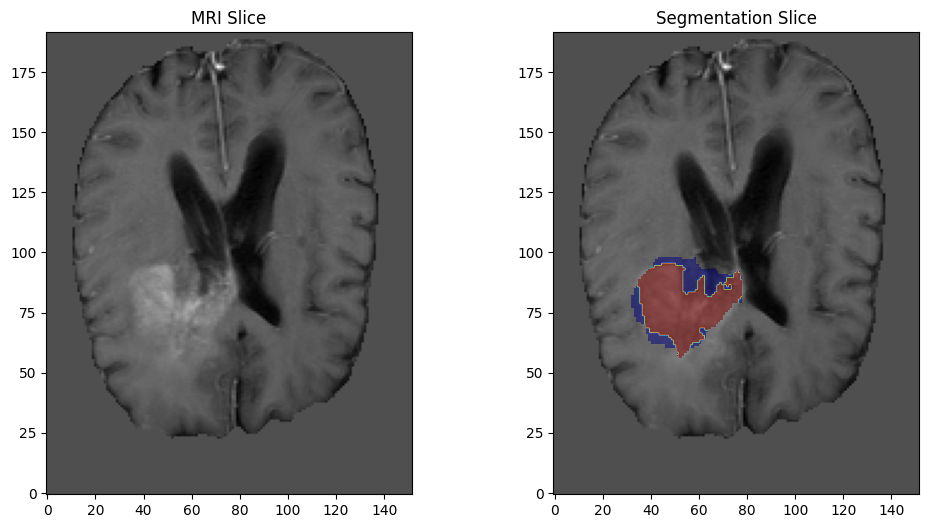

In [51]:
axis = 2
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice(sample_gt, axis))

### Plot Soft GTs

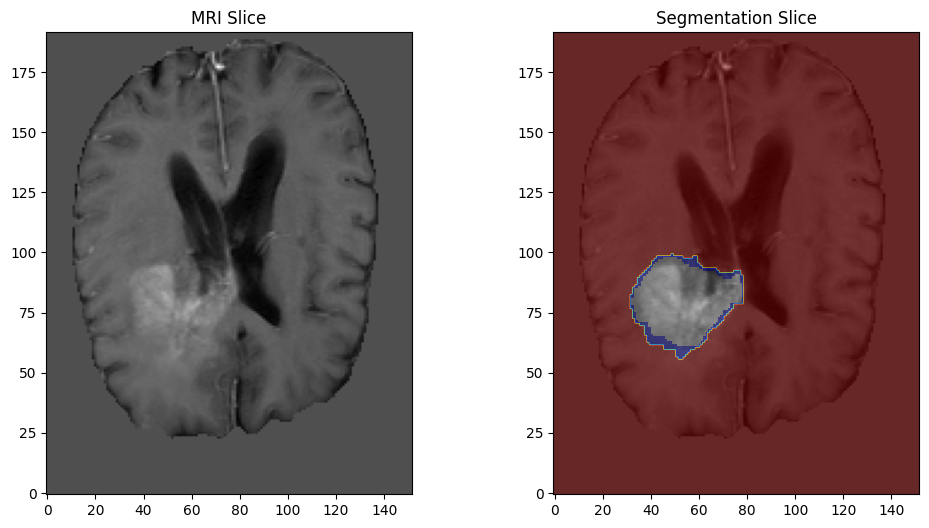

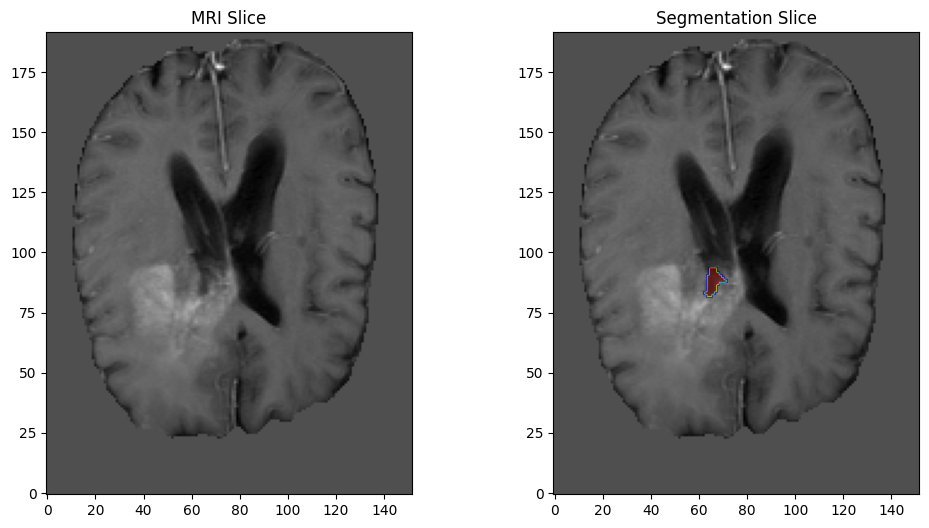

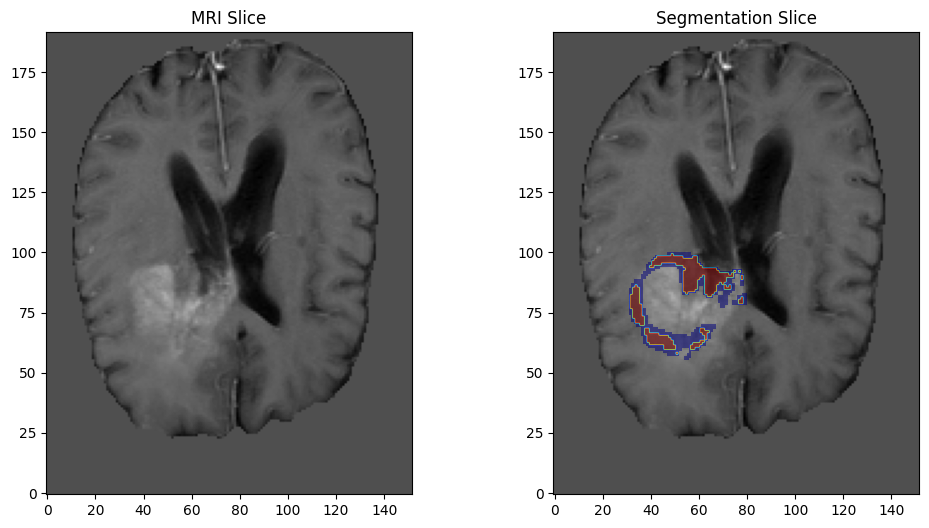

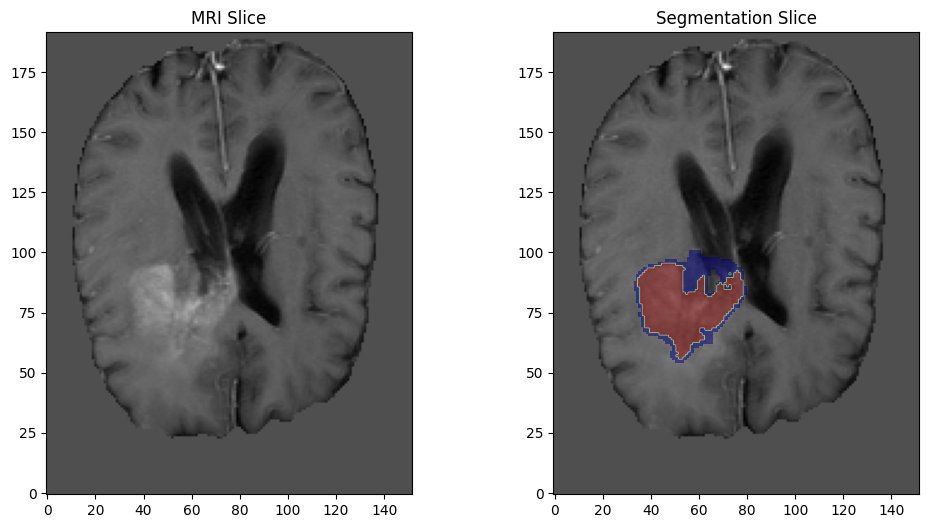

In [52]:
axis = 2
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice(sample_soft_gt[0], axis))
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice(sample_soft_gt[1], axis))
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice(sample_soft_gt[2], axis))
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice(sample_soft_gt[3], axis))

# With Dilation

In [14]:
dilate = 1
conf = Namespace(resize = (152, 192, 144), contrast = 'multimodal', one_hot = False, sigma = 0.25, do2D = False, soft=False, dilate=dilate, binary=False, ds_factor=None, experiment = 1)
bids_ds = BidsDataset(conf, data_dir+'/train')

In [15]:
idx = 0
sample = bids_ds[idx]
sample_img = sample['img']
sample_gt = sample['seg']
sample_soft_gt = sample['soft_seg']

 soft gt tensor shape before one_hot encoding torch.Size([240, 240, 155])
 soft gt tensor shape after one_hot encoding torch.Size([4, 240, 240, 155])
 soft gt tensor shape before dilation torch.Size([4, 240, 240, 155])
 soft gt tensor shape after dilation torch.Size([4, 240, 240, 155])
 soft gt tensor shape after softening torch.Size([4, 240, 240, 155])


## Looking at unique values etc.

In [16]:
test_temp_softmax(round_probs(sample_soft_gt, 1000))

normal vals:
unique values in soft gt: tensor([0.0000, 0.0010, 0.0020, 0.9990, 1.0000])
unique sums across all channels (metatensor([1.0000, 1.0010, 1.0020, 1.0020, 1.0030, 1.9990, 2.0000, 2.0010, 2.0020,
        2.0020, 2.9980, 2.9990, 3.0000, 3.0010, 3.9970, 3.9980, 3.9990, 4.0000]), metatensor([4092377,   18859,     524,     488,       9,   17934,   48296,    5145,
             39,      59,    1376,    7148,    9251,     219,      13,     156,
            358,     245]))
------------------------------------
Temperature: 0.1
unique values in soft gt: tensor([1.5133e-05, 1.5183e-05, 1.5183e-05, 1.5234e-05, 1.5285e-05, 1.5336e-05,
        1.5387e-05, 2.2699e-05, 2.2699e-05, 2.2699e-05, 2.2699e-05, 2.2699e-05,
        2.2699e-05, 2.2812e-05, 2.2812e-05, 2.2812e-05, 2.2927e-05, 2.2927e-05,
        2.2927e-05, 2.2927e-05, 2.3042e-05, 2.3042e-05, 2.3042e-05, 2.3157e-05,
        2.3157e-05, 2.3273e-05, 4.5394e-05, 4.5394e-05, 4.5394e-05, 4.5394e-05,
        4.5394e-05, 4.5394e-05, 4.5850e-0

In [ ]:
prob_normalization(round_probs(sample_soft_gt, 1000), temperature = 0.15)

## Plots

### Plot Hard GTs

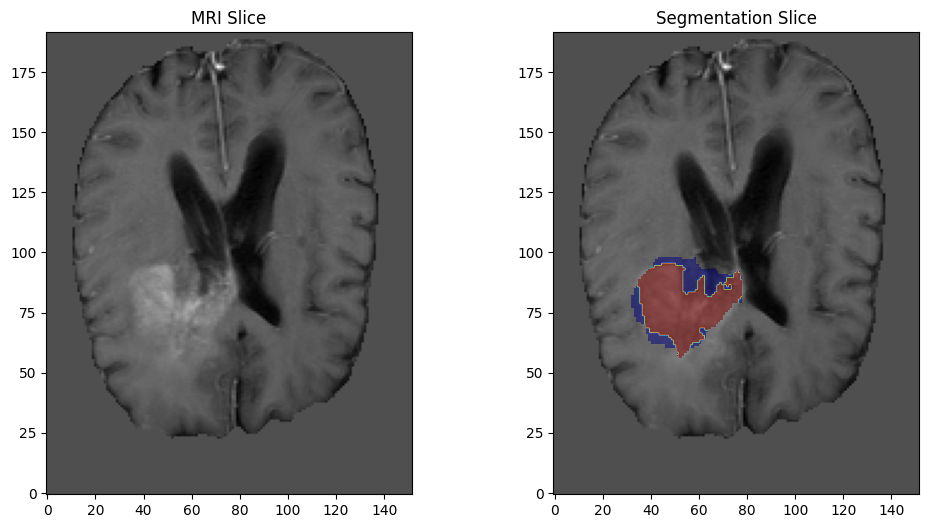

In [18]:
axis = 2
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice(sample_gt, axis))

### Plot Soft GTs

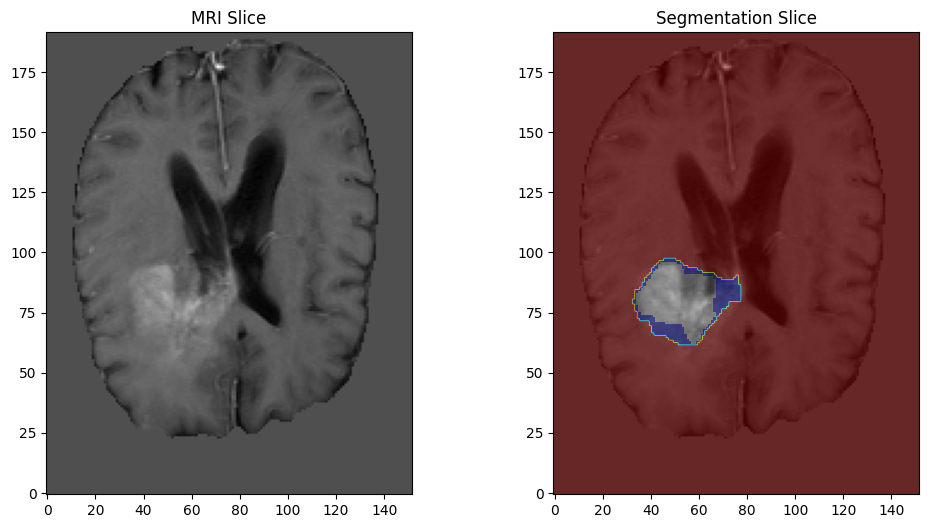

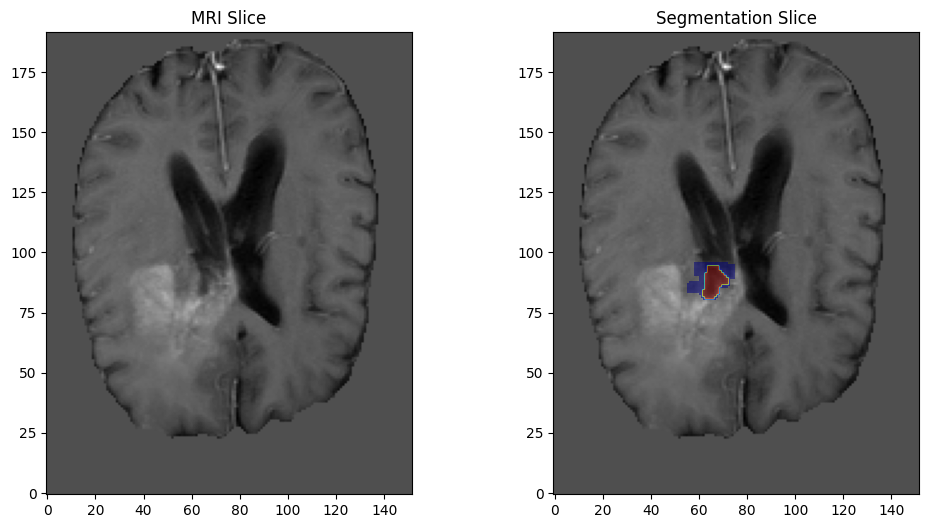

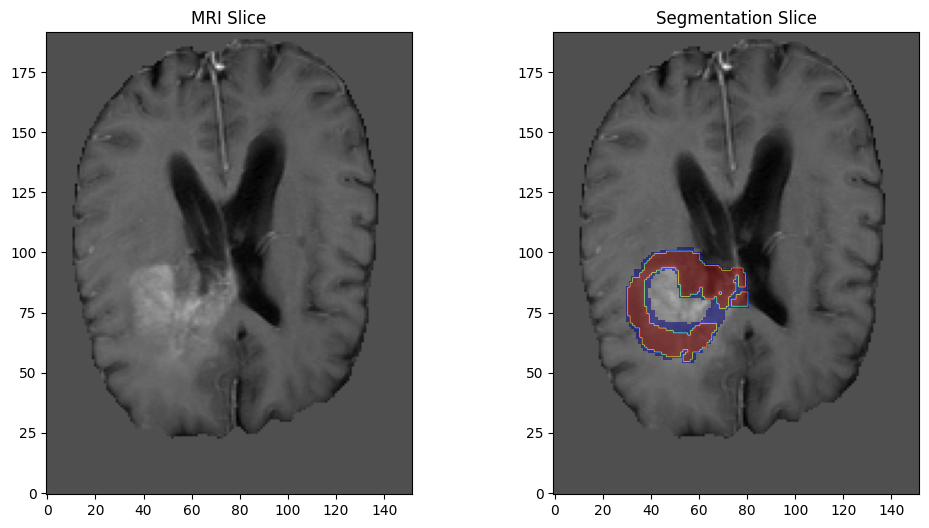

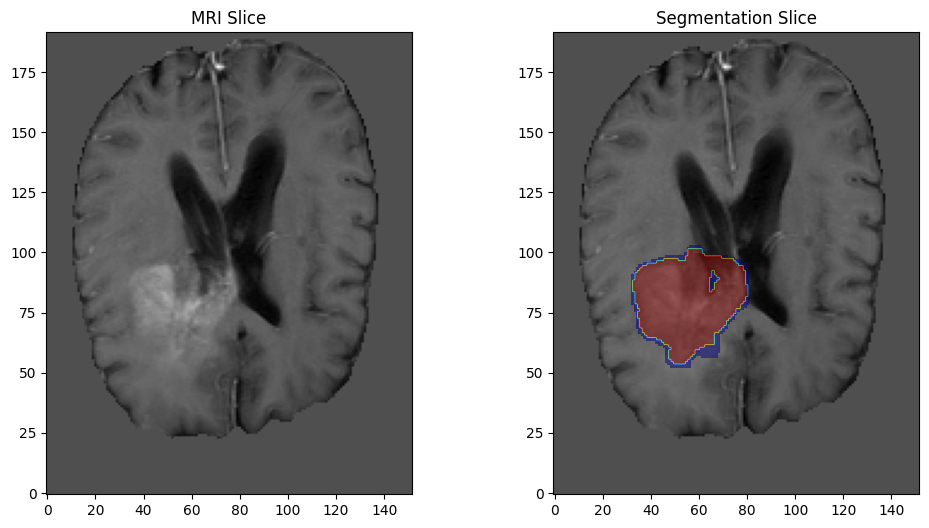

In [19]:
axis = 2
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice(sample_soft_gt[0], axis))
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice(sample_soft_gt[1], axis))
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice(sample_soft_gt[2], axis))
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice(sample_soft_gt[3], axis))

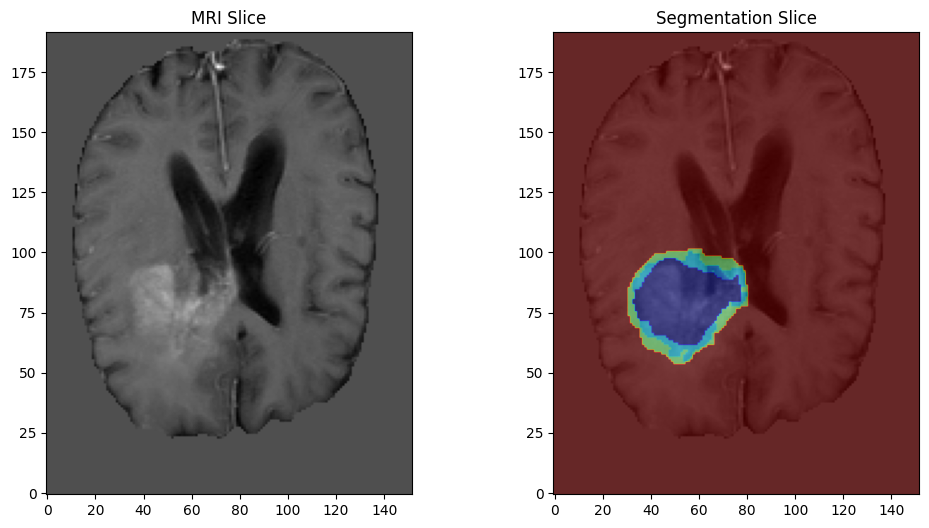

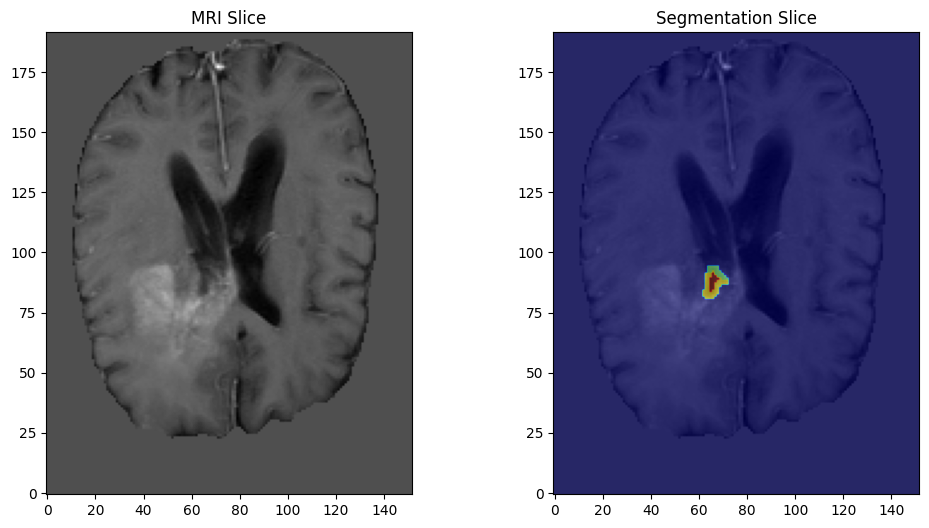

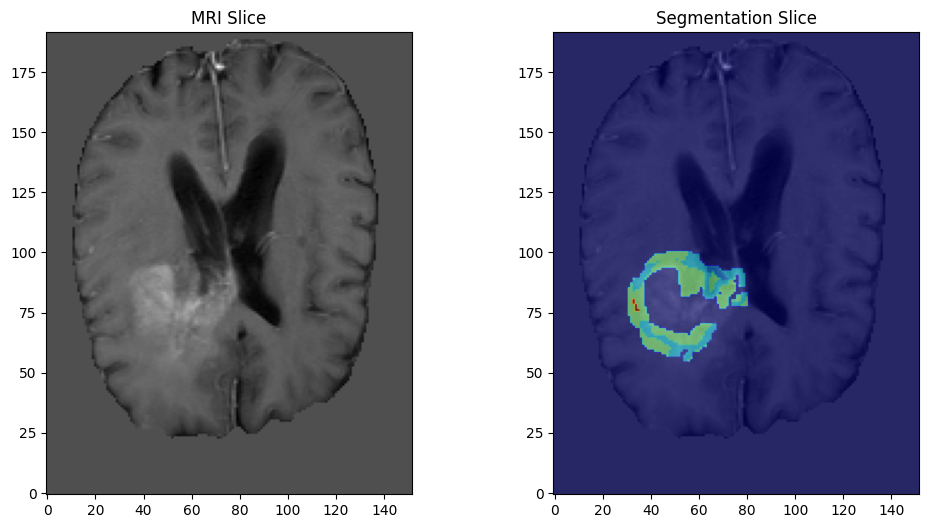

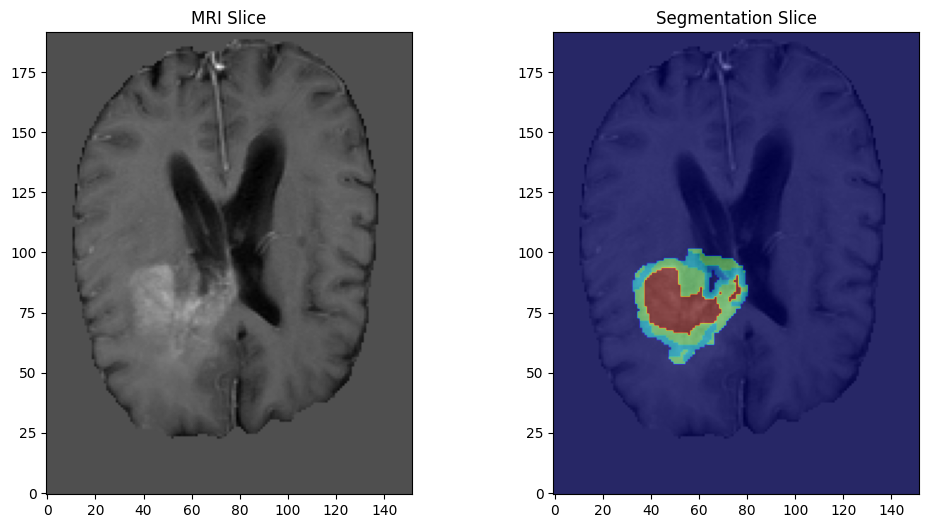

In [22]:
axis = 2
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice(temperature_scaled_softmax(sample_soft_gt,0.1)[0], axis))
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice(temperature_scaled_softmax(sample_soft_gt,0.1)[1], axis))
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice(temperature_scaled_softmax(sample_soft_gt,0.1)[2], axis))
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice(temperature_scaled_softmax(sample_soft_gt,0.1)[3], axis))

# Experiment 2

In [92]:
conf = Namespace(resize = (160, 192, 144), contrast = 'multimodal', one_hot = False, sigma = 0.25, do2D = False, soft=False, dilate=0, binary=True, ds_factor=2, experiment = 2)
bids_ds = BidsDataset(conf, data_dir+'/train')
print(bids_ds.opt)

Namespace(resize=(160, 192, 144), contrast='multimodal', one_hot=False, sigma=0.25, do2D=False, soft=False, dilate=0, binary=True, ds_factor=2, experiment=2)


In [93]:
idx = 0
sample = bids_ds[idx]
sample_img = sample['img']
sample_gt = sample['seg']
sample_soft_gt = sample['soft_seg']

## Looking at unique values etc.

In [94]:
print(f"unique values in soft gt: {torch.unique(sample_soft_gt)}")
print(f"unique sums across all channels {torch.unique(sample_soft_gt.sum(dim=0))}")

unique values in soft gt: tensor([0.0000, 0.1250, 0.2500, 0.3750, 0.5000, 0.6250, 0.7500, 0.8750, 1.0000])
unique sums across all channels tensor([1.])


In [95]:
normalized_soft_gt = softmax(sample_soft_gt)
print(f"unique values in soft gt: {torch.unique(normalized_soft_gt)}")
print(f"unique sums across all channels {torch.unique(normalized_soft_gt.sum(dim=0))}")

unique values in soft gt: tensor([0.2689, 0.3208, 0.3775, 0.4378, 0.5000, 0.5622, 0.6225, 0.6792, 0.7311])
unique sums across all channels tensor([1.])


In [96]:
if bool(relu(sample_soft_gt).max()):
    normalized_soft_gt = relu(sample_soft_gt)/relu(sample_soft_gt).max() 
else:
    normalized_soft_gt  = relu(sample_soft_gt)  # applying ReLU to the logits to get probabilites

print(f"unique values in soft gt: {torch.unique(normalized_soft_gt)}")
print(f"unique sums across all channels {torch.unique(normalized_soft_gt.sum(dim=0))}")

unique values in soft gt: tensor([0.0000, 0.1250, 0.2500, 0.3750, 0.5000, 0.6250, 0.7500, 0.8750, 1.0000])
unique sums across all channels tensor([1.])


## Plots

### Plot Hard GTs

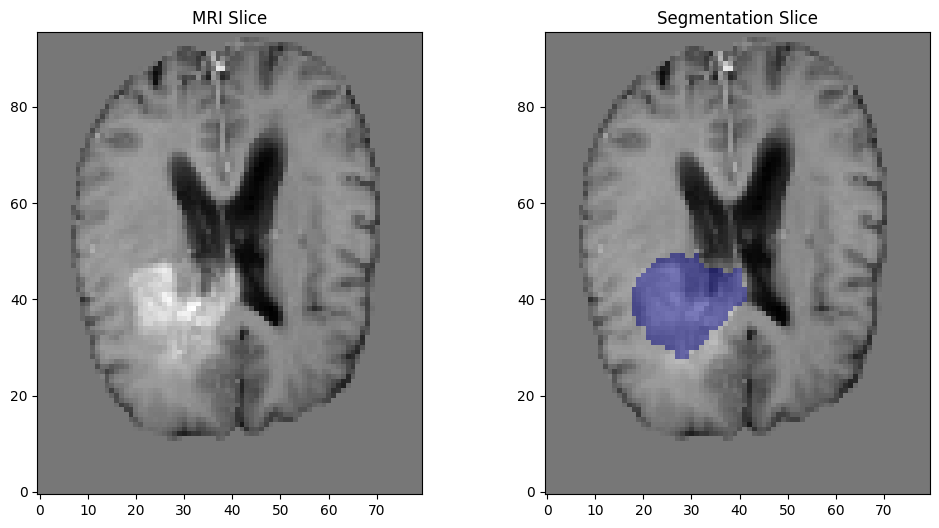

In [57]:
axis = 2
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice(sample_gt, axis))

### Plot Soft GTs

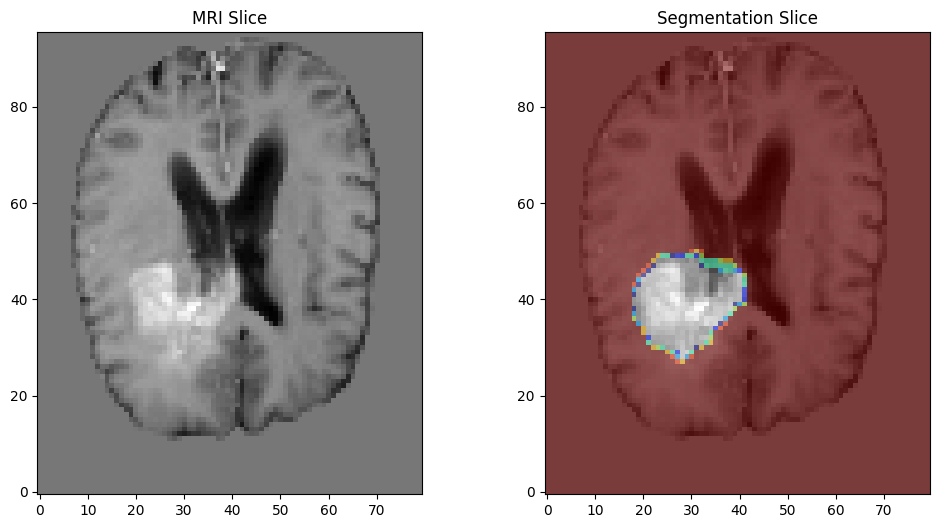

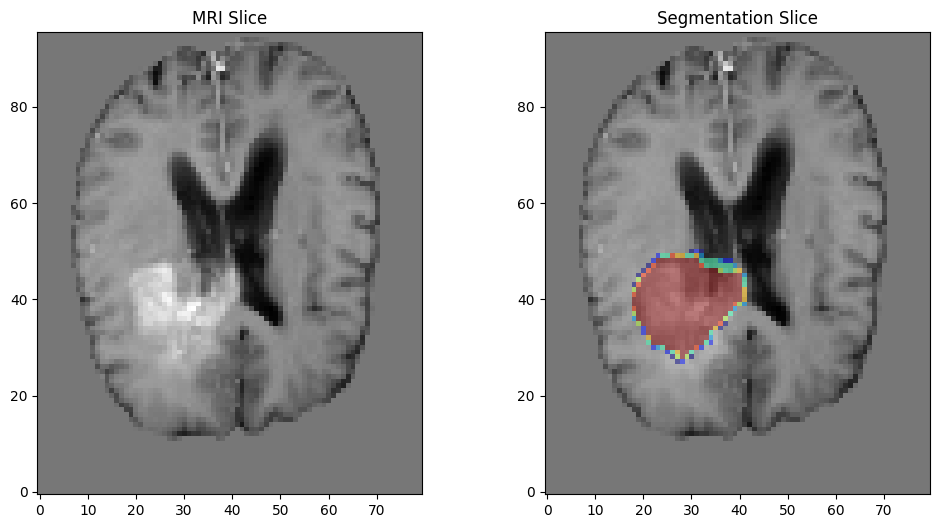

In [58]:
axis = 2
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice(sample_soft_gt[0], axis))
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice(sample_soft_gt[1], axis))

# With Dilation

In [97]:
dilate = 1
conf = Namespace(resize = (160, 192, 144), contrast = 'multimodal', one_hot = False, sigma = 0.25, do2D = False, soft=False, dilate=0, binary=True, ds_factor=2, experiment = 2)
bids_ds = BidsDataset(conf, data_dir+'/train')
print(bids_ds.opt)

Namespace(resize=(160, 192, 144), contrast='multimodal', one_hot=False, sigma=0.25, do2D=False, soft=False, dilate=0, binary=True, ds_factor=2, experiment=2)


In [98]:
idx = 0
sample = bids_ds[idx]
sample_img = sample['img']
sample_gt = sample['seg']
sample_soft_gt = sample['soft_seg']

## Looking at unique values etc.

In [99]:
print(f"unique values in soft gt: {torch.unique(sample_soft_gt)}")
print(f"unique sums across all channels {torch.unique(sample_soft_gt.sum(dim=0))}")

unique values in soft gt: tensor([0.0000, 0.1250, 0.2500, 0.3750, 0.5000, 0.6250, 0.7500, 0.8750, 1.0000])
unique sums across all channels tensor([1.])


In [100]:
normalized_soft_gt = softmax(sample_soft_gt)
print(f"unique values in soft gt: {torch.unique(normalized_soft_gt)}")
print(f"unique sums across all channels {torch.unique(normalized_soft_gt.sum(dim=0))}")

unique values in soft gt: tensor([0.2689, 0.3208, 0.3775, 0.4378, 0.5000, 0.5622, 0.6225, 0.6792, 0.7311])
unique sums across all channels tensor([1.])


In [101]:
if bool(relu(sample_soft_gt).max()):
    normalized_soft_gt = relu(sample_soft_gt)/relu(sample_soft_gt).max() 
else:
    normalized_soft_gt  = relu(sample_soft_gt)  # applying ReLU to the logits to get probabilites

print(f"unique values in soft gt: {torch.unique(normalized_soft_gt)}")
print(f"unique sums across all channels {torch.unique(normalized_soft_gt.sum(dim=0))}")

unique values in soft gt: tensor([0.0000, 0.1250, 0.2500, 0.3750, 0.5000, 0.6250, 0.7500, 0.8750, 1.0000])
unique sums across all channels tensor([1.])


## Plots

### Plot Hard GTs

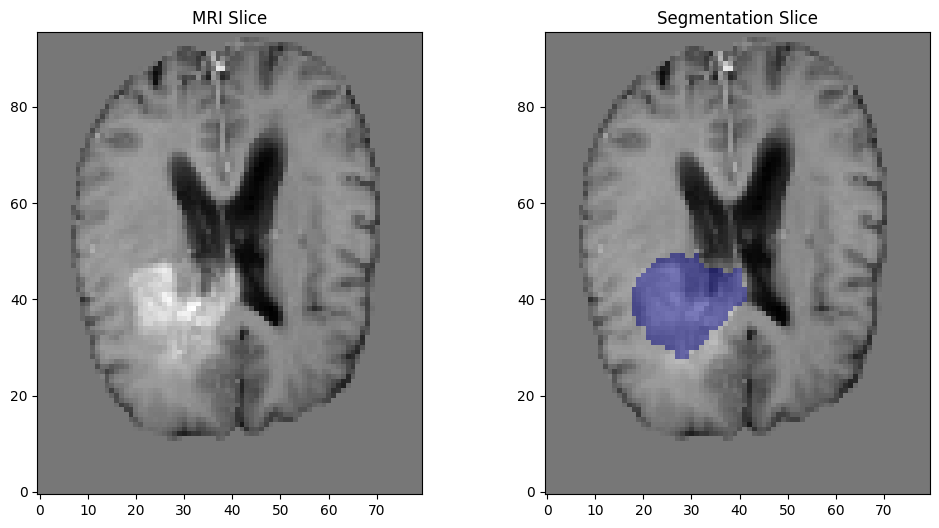

In [63]:
axis = 2
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice(sample_gt, axis))

### Plot Soft GTs

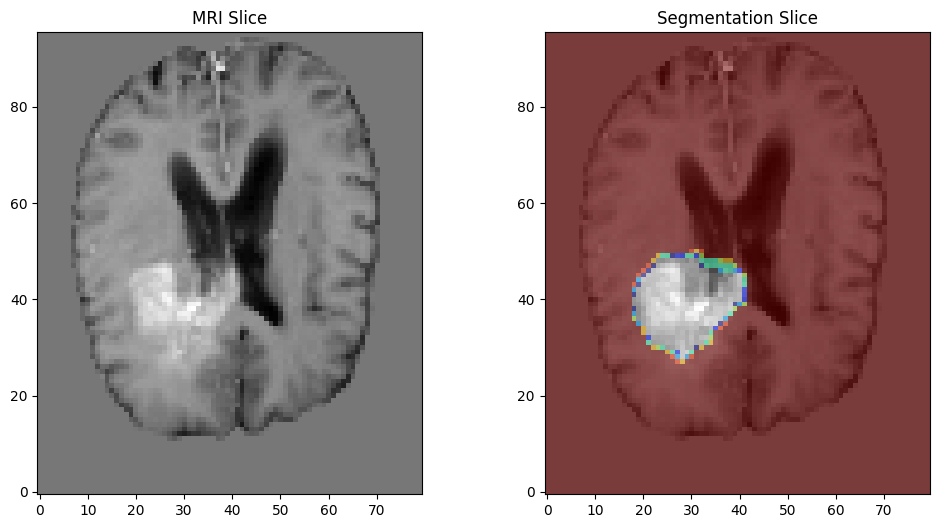

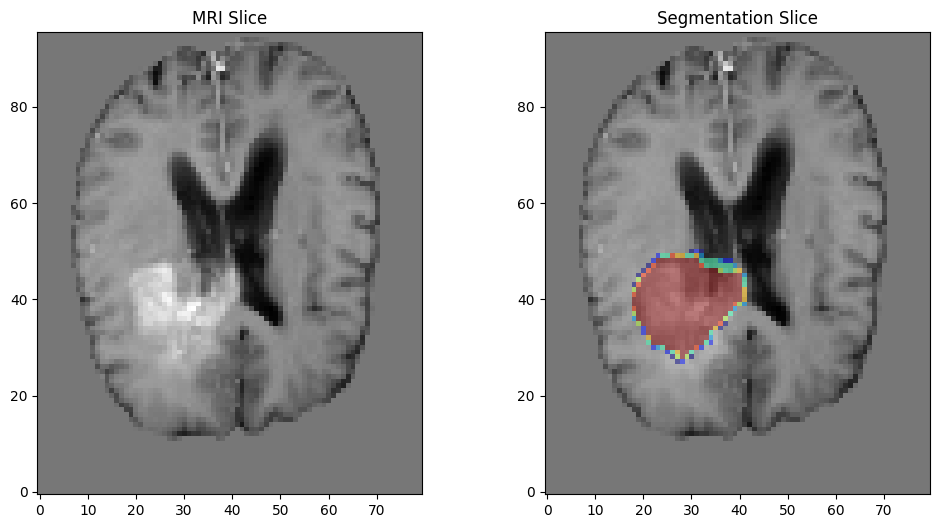

In [64]:
axis = 2
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice(sample_soft_gt[0], axis))
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice(sample_soft_gt[1], axis))

# Experiment 3

In [74]:
conf = Namespace(resize = (152, 192, 144), contrast = 'multimodal', one_hot = False, sigma = 0.25, do2D = False, soft=False, dilate=0, binary=True, ds_factor=2, experiment=3)
bids_ds = BidsDataset(conf, data_dir+'/train')

In [75]:
idx = 0
sample = bids_ds[idx]
sample_img = sample['img']
sample_gt = sample['seg']
sample_soft_gt = sample['soft_seg']

## Looking at unique values etc.

In [76]:
print(f"unique values in soft gt: {torch.unique(sample_soft_gt)}")
print(f"unique sums across all channels {torch.unique(sample_soft_gt.sum(dim=0))}")

unique values in soft gt: tensor([0.0000e+00, 3.7675e-11, 7.5351e-11, 1.1303e-10, 1.1231e-07, 1.1235e-07,
        1.1238e-07, 1.1242e-07, 2.2466e-07, 2.2469e-07, 2.2473e-07, 2.2477e-07,
        3.3696e-07, 3.3700e-07, 3.3704e-07, 3.3708e-07, 4.4931e-07, 4.4935e-07,
        4.4939e-07, 4.4942e-07, 5.6162e-07, 5.6166e-07, 5.6170e-07, 5.6173e-07,
        3.3479e-04, 3.3479e-04, 3.3490e-04, 3.3490e-04, 3.3490e-04, 3.3501e-04,
        3.3501e-04, 3.3501e-04, 3.3501e-04, 3.3501e-04, 3.3513e-04, 3.3513e-04,
        3.3513e-04, 3.3513e-04, 3.3513e-04, 3.3524e-04, 3.3524e-04, 3.3524e-04,
        3.3524e-04, 3.3524e-04, 3.3535e-04, 3.3535e-04, 3.3535e-04, 3.3535e-04,
        3.3535e-04, 3.3546e-04, 3.3546e-04, 3.3546e-04, 3.3546e-04, 3.3557e-04,
        3.3557e-04, 3.3557e-04, 3.3569e-04, 6.6969e-04, 6.6969e-04, 6.6980e-04,
        6.6980e-04, 6.6991e-04, 6.6991e-04, 6.6991e-04, 6.7003e-04, 6.7003e-04,
        6.7003e-04, 6.7014e-04, 6.7014e-04, 6.7014e-04, 6.7025e-04, 6.7025e-04,
        6.7025

In [ ]:
normalized_soft_gt = softmax(sample_soft_gt)
print(f"unique values in soft gt: {torch.unique(normalized_soft_gt)}")
print(f"unique sums across all channels {torch.unique(normalized_soft_gt.sum(dim=0))}")

In [77]:
if bool(relu(sample_soft_gt).max()):
    normalized_soft_gt = relu(sample_soft_gt)/relu(sample_soft_gt).max() 
else:
    normalized_soft_gt  = relu(sample_soft_gt)  # applying ReLU to the logits to get probabilites

print(f"unique values in soft gt: {torch.unique(normalized_soft_gt)}")
print(f"unique sums across all channels {torch.unique(normalized_soft_gt.sum(dim=0))}")

unique values in soft gt: tensor([0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.2691, 0.2691, 0.2691,
        0.2691, 0.2691, 0.2691, 0.2691, 0.2691, 0.2691, 0.2692, 0.2692, 0.2692,
        0.2692, 0.2692, 0.2692, 0.2692, 0.2692, 0.2692, 0.2693, 0.2693, 0.2693,
        0.2693, 0.2693, 0.2693, 0.2693, 0.2695, 0.2695, 0.2695, 0.2695, 0.2695,
        0.2695, 0.2696, 0.2696, 0.2696, 0.7304, 0.7304, 0.7305, 0.7305, 0.7305,
        0.7305, 0.7305, 0.7307, 0.7307, 0.7307, 0.7307, 0.7308, 0.7308, 0.7308,
        0.7308, 0.7308, 0.7308, 0.7309, 0.7309, 0.7309, 0.7309, 0.7309, 0.7309,
        0.7311, 0.7311, 0.7311, 0.7311])
unique sums across all channels tensor([1.0000, 1.0000])


## Plots

### Plot Hard GTs

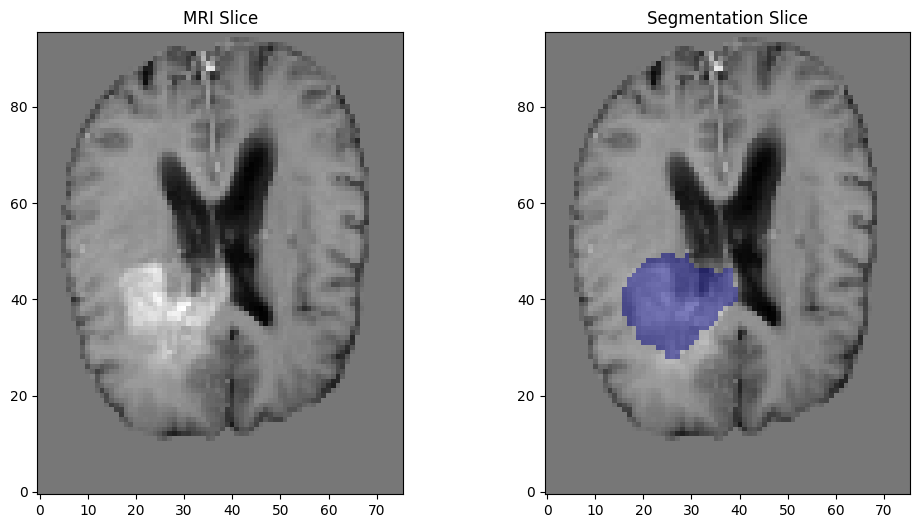

In [78]:
axis = 2
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice(sample_gt, axis))

### Plot Soft GTs

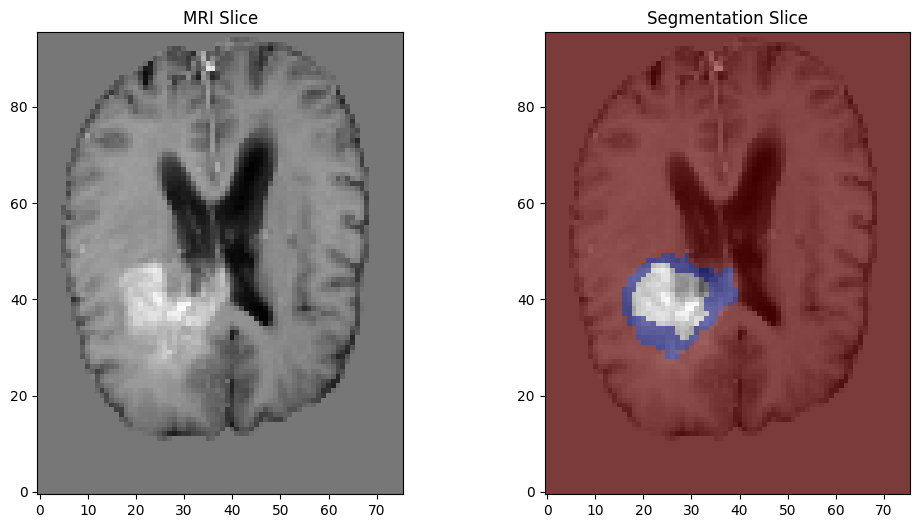

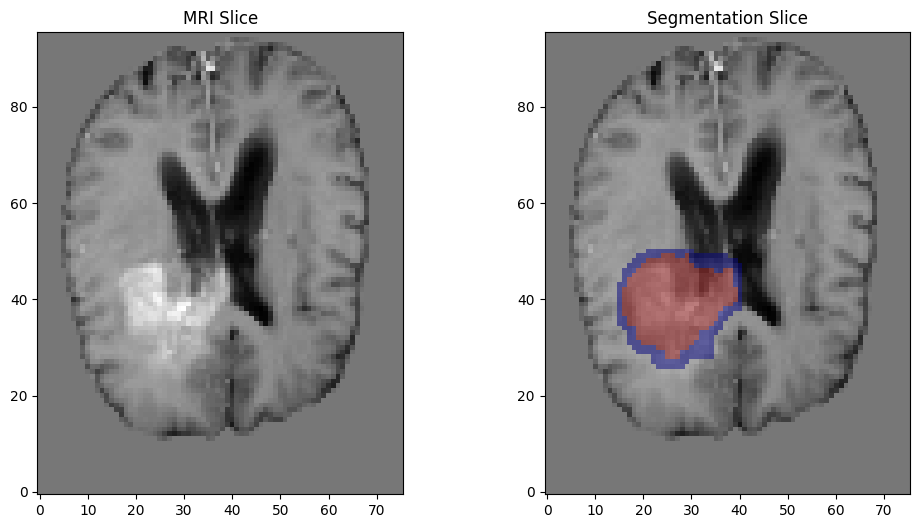

In [79]:

axis = 2
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice(sample_soft_gt[0], axis))
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice(sample_soft_gt[1], axis))

# With Dilation

In [80]:
dilate = 1
conf = Namespace(resize = (152, 192, 144), contrast = 'multimodal', one_hot = False, sigma = 0.125, do2D = False, soft=False, dilate=0, binary=True, ds_factor=2, experiment=3)
bids_ds = BidsDataset(conf, data_dir+'/train')
print(bids_ds.opt)

Namespace(resize=(152, 192, 144), contrast='multimodal', one_hot=False, sigma=0.125, do2D=False, soft=False, dilate=0, binary=True, ds_factor=2, experiment=3)


In [81]:
idx = 0
sample = bids_ds[idx]
sample_img = sample['img']
sample_gt = sample['seg']
sample_soft_gt = sample['soft_seg']

## Looking at unique values etc.

In [82]:
print(f"unique values in soft gt: {torch.unique(sample_soft_gt)}")
print(f"unique sums across all channels {torch.unique(sample_soft_gt.sum(dim=0))}")

unique values in soft gt: tensor([0.0000e+00, 2.0305e-42, 4.0624e-42, 6.0928e-42, 1.6038e-28, 3.2076e-28,
        4.8114e-28, 6.4152e-28, 8.0191e-28, 1.2664e-14, 2.5328e-14, 3.7992e-14,
        5.0657e-14, 6.3321e-14, 1.0000e+00])
unique sums across all channels tensor([1.])


In [ ]:
normalized_soft_gt = softmax(sample_soft_gt)
print(f"unique values in soft gt: {torch.unique(normalized_soft_gt)}")
print(f"unique sums across all channels {torch.unique(normalized_soft_gt.sum(dim=0))}")

In [ ]:
if bool(relu(sample_soft_gt).max()):
    normalized_soft_gt = relu(sample_soft_gt)/relu(sample_soft_gt).max() 
else:
    normalized_soft_gt  = relu(sample_soft_gt)  # applying ReLU to the logits to get probabilites

print(f"unique values in soft gt: {torch.unique(normalized_soft_gt)}")
print(f"unique sums across all channels {torch.unique(normalized_soft_gt.sum(dim=0))}")

## Plots

### Plot Hard GTs

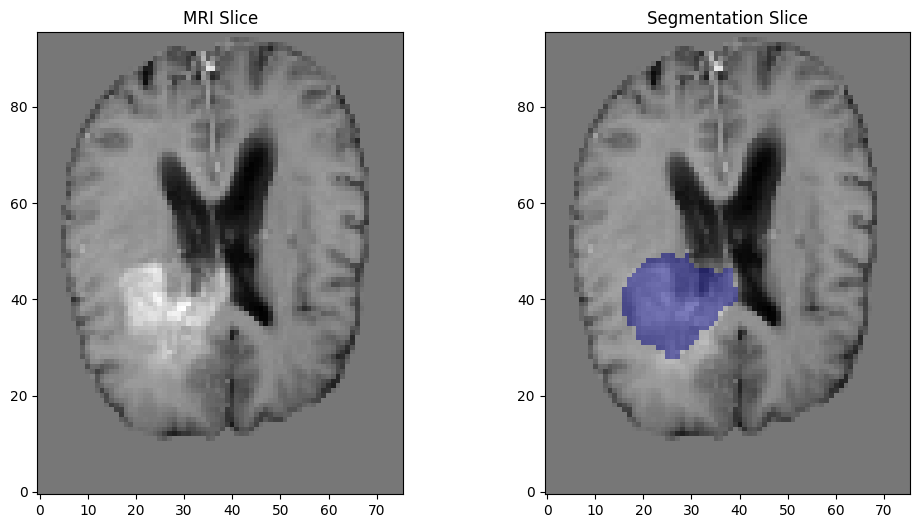

In [83]:
axis = 2
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice(sample_gt, axis))

### Plot Soft GTs

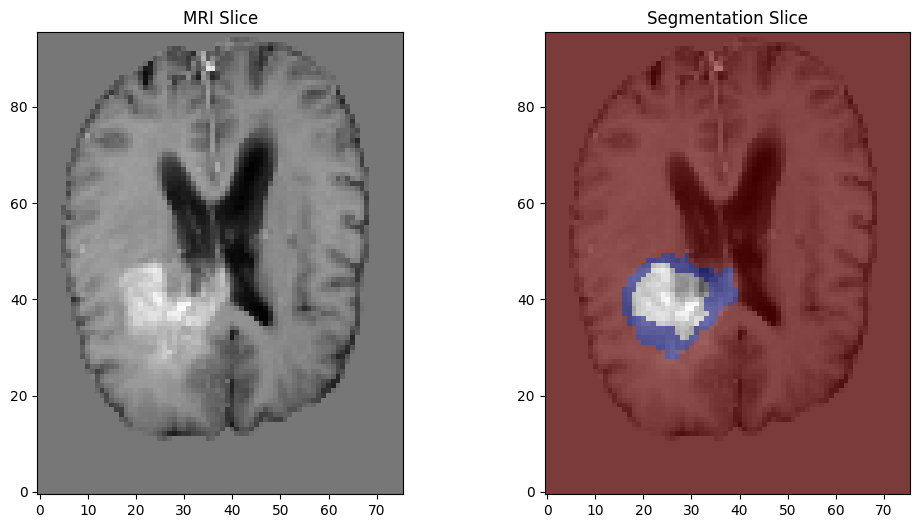

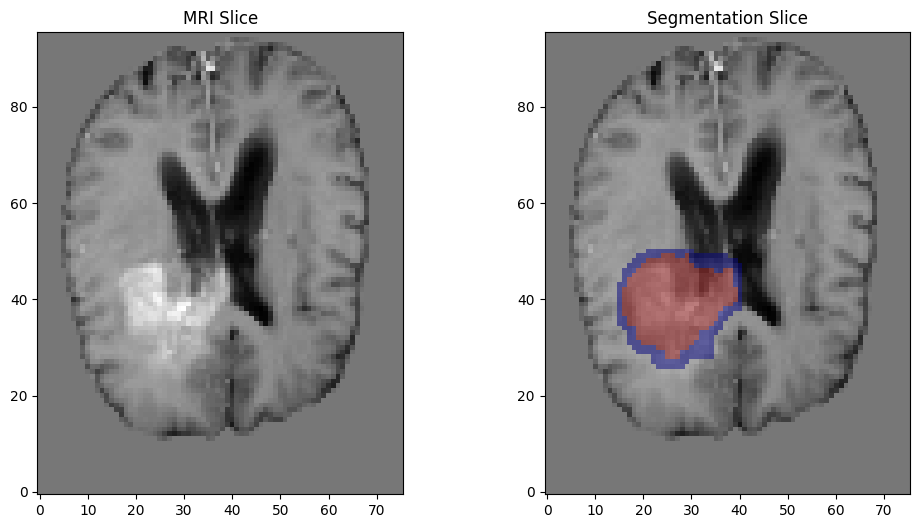

In [84]:
axis = 2
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice(sample_soft_gt[0], axis))
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice(sample_soft_gt[1], axis))